# HW3 - John Pezzuto

### Load Packages, Data, & Functions

In [2]:
import numpy as np
import scipy.optimize as opt
import scipy.stats as sts
import matplotlib.pyplot as plt
import pandas as pd
import pylab as pl
import scipy.integrate as intgr
import numpy.linalg as lin
plt.style.use("ggplot")
%matplotlib inline

In [3]:
incomes = np.loadtxt('incomes.txt')
sick = pd.read_csv("sick.txt")
#simulated income
inc_sim = np.linspace(0.000001, 150000, 200)

In [4]:
def trunc_lognorm_pdf(xvals, mu, sigma, cutoff): #set up for lognorm
    if cutoff == 'None':
        prob_notcut = 1.0
    else:
        prob_notcut = sts.lognorm.cdf(cutoff, s=sigma, loc=mu, scale=np.exp(mu))
            
    log_pdf_vals = (((1/(xvals * sigma * np.sqrt(2 * np.pi))) *
                    np.exp( - ((np.log(xvals)) - mu)**2 / (2 * sigma**2))) / 
                    prob_notcut)
    return log_pdf_vals 

## data mean & std
def data_moments(xvals):
    mean_data = xvals.mean()
    std_data = xvals.std() #set up for standard deviation instead of var
    return mean_data, std_data

## model mean & std
def model_moments(mu, sigma, cutoff):
    xfx = lambda x: x * trunc_lognorm_pdf(x, mu, sigma, cutoff)
    (mean_model, m_m_err) = intgr.quad(xfx, 0.00001, cutoff)
    x2fx = lambda x: ((x - mean_model) ** 2) * trunc_lognorm_pdf(x, mu, sigma, cutoff) 
    (var_model, v_m_err) = intgr.quad(x2fx, 0.00001, cutoff)
    std_model = np.sqrt(var_model)#set up for sd at this line
    return mean_model, std_model

#use data and model stats to find error
def err_vec(xvals, mu, sigma, cutoff, simple):
    mean_data, std_data = data_moments(xvals) 
    moms_data = np.array([[mean_data], [std_data]])
    mean_model, std_model = model_moments(mu, sigma, cutoff)
    moms_model = np.array([[mean_model], [std_model]])
    if simple:
        err_vec = moms_model - moms_data #difference
    else:
        err_vec = (moms_model - moms_data) / moms_data #percent deviation
    
    return err_vec

## weighted sum of squared moment errors
def criterion(params, *args):
    mu, sigma = params
    xvals, cutoff, W = args
    err = err_vec(xvals, mu, sigma, cutoff, simple=False)
    crit_val = np.dot(np.dot(err.T, W), err)
    
    return crit_val

## a) Plot a Histogram

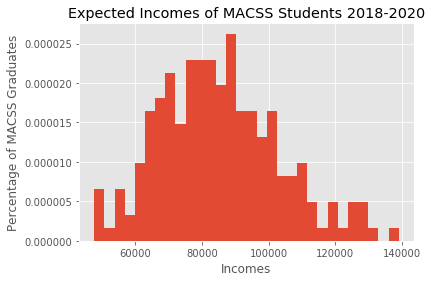

In [5]:
plt.hist(incomes, bins = 30, normed = True, label = 'Actual Outcomes')
plt.title("Expected Incomes of MACSS Students 2018-2020")
plt.xlabel("Incomes")
plt.ylabel("Percentage of MACSS Graduates")

## b) Estimate the parameters of the lognormal distribution by generalized method of moments

In [17]:
mu_init = 11
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(2) #usin

gmm_args = (incomes, 150000, W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))

GMM1_Value = criterion(params_init, *gmm_args)[0][0]
mu_GMM1, sig_GMM1 = results.x
print('mu_GMM1=', mu_GMM1, ' sig_GMM1=', sig_GMM1, "criterion value=", GMM1_Value)

mu_GMM1= 11.3335962334  sig_GMM1= 0.213255512271 criterion value= 0.402336498184


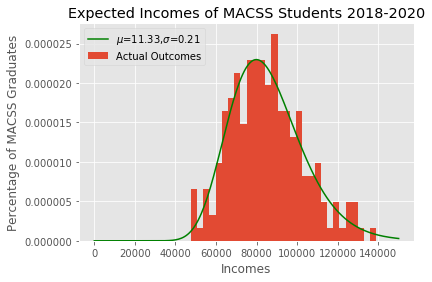

In [7]:
plt.hist(incomes, bins = 30, normed = True, label = 'Actual Outcomes')
plt.title("Expected Incomes of MACSS Students 2018-2020")
plt.xlabel("Incomes")
plt.ylabel("Percentage of MACSS Graduates")
plt.plot(inc_sim, trunc_lognorm_pdf(inc_sim, mu_GMM1, sig_GMM1, 150000), color = 'g', label = '$\mu$=11.33,$\sigma$=0.21')
plt.legend(loc = 'upper left')

## c) Two-Step GMM Estimation

In [36]:
err1 = err_vec(incomes, mu_GMM1, sig_GMM1, 150000, False) #should be using real data
VCV2 = np.dot(err1, err1.T) / incomes.shape[0]
print('VCV: \n', VCV2)
W_hat2 = lin.pinv(VCV2) #new W-hat
print('\nNew W-hat:\n', W_hat2)

VCV: 
 [[  2.02376119e-17   1.45315902e-17]
 [  1.45315902e-17   1.04343889e-17]]

New W-hat
 [[  2.15117157e+16   1.54464587e+16]
 [  1.54464587e+16   1.10913090e+16]]


In [37]:
#note this is slow
#step 2: re-estimate the GMM estimator
params_init1 = np.array([mu_GMM1, sig_GMM1])
gmm_args2 = (incomes, 150000, W_hat2) #difference is new W-hat
results2 = opt.minimize(criterion, params_init1, args=(gmm_args2),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM2, sig_GMM2 = results2.x #new estimates

# get criterion function values at the estimated GMM parameter values
params_GMM2 = np.array([mu_GMM2, sig_GMM2])
GMM2_Value = criterion(params_GMM2, *gmm_args2)[0][0]

# compare model moments and data moments
mean_data, std_data = data_moments(incomes)
mean_model2, std_model2 = model_moments(mu_GMM2, sig_GMM2, 150000)
print('mu_GMM2=', mu_GMM2, ' sig_GMM2=', sig_GMM2, "criterion value:", GMM2_Value, '\n')
print('mean of data: {:.5f} , standard deviation of data: {:.5f}'.format(mean_data,std_data))
print('mean of model: {:.5f} , standard deviation of model: {:.5f}'.format(mean_model2,std_model2))

mu_GMM2= 11.3335961931  sig_GMM2= 0.213255500643 criterion value: 0.002614550682 

mean of data: 85276.82361 , standard deviation of data: 17992.54213
mean of model: 85276.82561 , standard deviation of model: 17992.54153


##### we nototiced that even though the parameters did not change much, the criterion value is significatly smaller

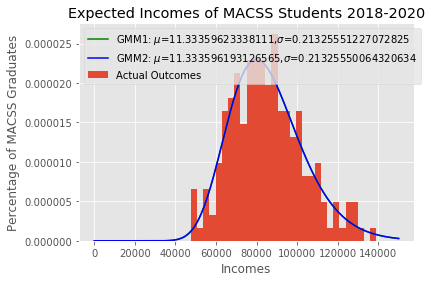

In [26]:
inc_sim = np.linspace(0.000001, 150000, 200)
plt.hist(incomes, bins = 30, normed = True, label = 'Actual Outcomes')
plt.title("Expected Incomes of MACSS Students 2018-2020")
plt.xlabel("Incomes")
plt.ylabel("Percentage of MACSS Graduates")
plt.plot(inc_sim, trunc_lognorm_pdf(inc_sim, mu_GMM1, sig_GMM1, 150000), color = 'g', label = 'GMM1: $\mu$={},$\sigma$={}'.format(mu_GMM1,sig_GMM1))
plt.plot(inc_sim, trunc_lognorm_pdf(inc_sim, mu_GMM2, sig_GMM2, 150000), color = 'b', label = 'GMM2: $\mu$={},$\sigma$={}'.format(mu_GMM2,sig_GMM2))
plt.legend(loc = 'upper left')

##### here we note that the two lines are almost identical

## d) GMM Estimate With 3 Moments

In [38]:
#3 moments
def data_moments3(xvals):
    bpct_1 = xvals[xvals < 75000].shape[0] / xvals.shape[0]
    bpct_2 = (xvals[(xvals >=75000) & (xvals <= 100000)].shape[0] /
                  xvals.shape[0])
    bpct_3 = xvals[xvals > 100000].shape[0] / xvals.shape[0]
    
    return bpct_1, bpct_2, bpct_3

def model_moments3(mu, sigma, cutoff): #note sigma normal
    xfx = lambda x: trunc_lognorm_pdf(x, mu, sigma, cutoff)
    (bpct_1_mod, bp_1_err) = intgr.quad(xfx, 0.001, 75000)
    (bpct_2_mod, bp_2_err) = intgr.quad(xfx, 75000, 100000)
    (bpct_3_mod, bp_3_err) = intgr.quad(xfx, 100000, 150000)
    
    return bpct_1_mod, bpct_2_mod, bpct_3_mod


def err_vec3(xvals, mu, sigma, cutoff, simple):
    bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments3(xvals)
    
    moms_data = np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat]])
    bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments3(mu, sigma, cutoff)
    moms_model = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = 100 * ((moms_model - moms_data) / moms_data)
    
    return err_vec


def criterion3(params, *args):
    mu, sigma = params
    xvals, cutoff, W = args
    err = err_vec3(xvals, mu, sigma, cutoff, simple=False)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val    


data moments:
 (0.3, 0.5, 0.2)
model moments:
 (0.30000077296087635, 0.5000021515548901, 0.20000033522748709)

mu: 11.3367051569 sigma: 0.211513243846 criterion value: 2.79647295543e-07


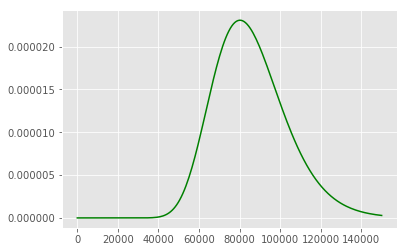

In [43]:
mu_init1 = 11
sig_init1 = 0.5
params_init2 = np.array([mu_init1, sig_init1])
W_hat3 = np.eye(3) 


gmm_args3 = (incomes, 150000, W_hat3)
results3 = opt.minimize(criterion3, params_init2, args=(gmm_args3),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None))) 
mu_GMM_3, sig_GMM_3 = results3.x

# critereon function at new values
params_GMM3 = np.array([mu_GMM_3, sig_GMM_3])
GMM3_Value = criterion3(params_GMM3, *gmm_args3)[0][0]

# compare model moments and data moments
print('data moments:\n',data_moments3(incomes))
print('model moments:\n', model_moments3(mu_GMM_3, sig_GMM_3, 150000))


print("\nmu:",mu_GMM_3, "sigma:",sig_GMM_3, "criterion value:", GMM3_Value)

plt.plot(inc_sim, trunc_lognorm_pdf(inc_sim, mu_GMM_3, sig_GMM_3, 150000), color = 'green', label = 'GMM_3: $\mu$=11.33,$\sigma$=.21')


### Plot Results

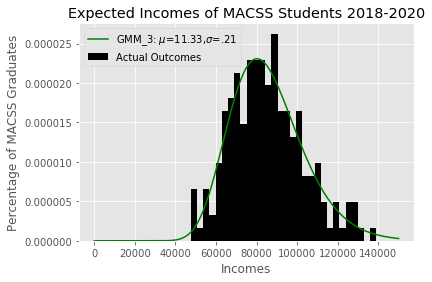

In [29]:
inc_sim = np.linspace(0.0001, 150000, 200)
plt.hist(incomes, bins = 30, normed = True, color = "black",label = 'Actual Outcomes')
plt.title("Expected Incomes of MACSS Students 2018-2020")
plt.xlabel("Incomes")
plt.ylabel("Percentage of MACSS Graduates")
plt.plot(inc_sim, trunc_lognorm_pdf(inc_sim, mu_GMM_3, sig_GMM_3, 150000), color = 'green', label = 'GMM_3: $\mu$=11.33,$\sigma$=.21')
plt.legend(loc = 'upper left')

## e) GMM Estimate New Moments

In [30]:
# step 1: use vector of moment error function from part b to get a new estimate of the inverse variance-covariance matrix
err_3 = err_vec3(incomes, mu_GMM_3, sig_GMM_3, 150000, False) 
VCV_3 = np.dot(err_3, err_3.T) / incomes.shape[0] 
W_hat2_3 = lin.pinv(VCV_3) 

#step 2: re-estimate the GMM estimator
params_init_3 = np.array([mu_GMM_3, sig_GMM_3]) 
gmm_args2_3 = (incomes, 150000, W_hat2_3)
results3_2 = opt.minimize(criterion3, params_init_3, args=(gmm_args2_3), method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None))) 
mu_GMM2_3, sig_GMM2_3 = results3_2.x 

params_GMM2_3 = np.array([mu_GMM2_3, sig_GMM2_3])
GMM4_Value = criterion3(params_GMM2_3, *gmm_args2_3)[0][0]


print('data moments:\n',data_moments3(incomes))
print('model moments:\n', model_moments3(mu_GMM2_3, sig_GMM2_3, 150000))

print("\nmu:",mu_GMM2_3, "sigma:",sig_GMM2_3, "criterion value:", GMM4_Value)

plt.plot(inc_sim, trunc_lognorm_pdf(inc_sim, mu_GMM2_3, sig_GMM2_3, 150000), color = 'hotpink', label = 'GMM2_3: $\mu$={},$\sigma$={}'.format(mu_GMM2_3, sig_GMM2_3))


data moments:
 (0.3, 0.5, 0.2)
model moments:
 (0.29995570734262217, 0.49991938303271194, 0.2001281771702945)

mu: 11.3367619716 sigma: 0.211566084632 criterion value: 4.2640149224e-12


### Histogram

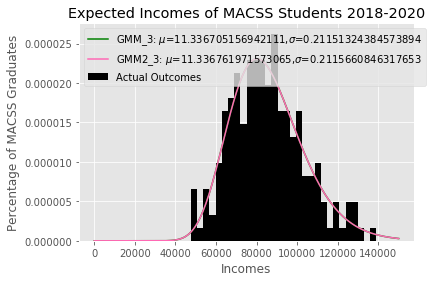

In [31]:
inc_sim = np.linspace(0.0001, 150000, 200)
plt.hist(incomes, bins = 30, normed = True, color = 'k', label = 'Actual Outcomes')
plt.title("Expected Incomes of MACSS Students 2018-2020")
plt.xlabel("Incomes")
plt.ylabel("Percentage of MACSS Graduates")
plt.plot(inc_sim, trunc_lognorm_pdf(inc_sim, mu_GMM_3, sig_GMM_3, 150000), color = 'green', label = 'GMM_3: $\mu$={},$\sigma$={}'.format(mu_GMM_3, sig_GMM_3))
plt.plot(inc_sim, trunc_lognorm_pdf(inc_sim, mu_GMM2_3, sig_GMM2_3, 150000), color = 'hotpink', label = 'GMM2_3: $\mu$={},$\sigma$={}'.format(mu_GMM2_3, sig_GMM2_3))

plt.legend(loc = 'upper left')

## f) Which of the four estimations from parts (b), (c), (d), and (e) fits the data best?

B is the best because it has the smallest criterion value

# 2) Linear regression and GMM 

In [45]:
def err_vec_lin(xvals, b0, b1, b2, b3): # call data and model statistics to compute error matrix

    moms_data = np.array([xvals['sick']]) #notice this is all hardcoded. sick is result
    moms_model = b0 + b1*xvals['age'] + b2*xvals['children'] + b3*xvals['avgtemp_winter']
    moms_model = np.array([moms_model])
    
    err_vec = moms_model - moms_data
    
    return err_vec

def criterion_lin(params, *args): # compute the criterion function
  
    b0, b1, b2, b3 = params
    xvals, W = args
    err = err_vec_lin(xvals, b0, b1, b2, b3) # get error matrix
    crit_val = np.dot(np.dot(err, W), err.T)  
    
    return crit_val

In [51]:
  m

My parameter estimates are: 0.251644863587 0.0129334709621 0.400500984743 -0.00999170970796
My criterion value is :  0.00182128980608


In [52]:
# set parameters for the minimizer
b0_init = 1 # initial guess for four parameters
b1_init = 0
b2_init = 0
b3_init = 0
 
#concat data
params_init_lin = np.array([b0_init, b1_init, b2_init, b3_init]) 
W_hat_lin = np.eye(incomes.shape[0]) # identity matrix. should be same as N
gmm_args_lin = (sick, W_hat_lin) # plug in data and the weighting matrix)

#minimize
results_lin = opt.minimize(criterion_lin, params_init_lin, args=(gmm_args_lin), method='L-BFGS-B') 
b0_gmm, b1_gmm, b2_gmm, b3_gmm = results_lin.x # unpack estimated parameters

# get criterion function values at the estimated GMM parameter values
params_GMM_lin = np.array([b0_gmm, b1_gmm, b2_gmm, b3_gmm])
GMM_Value_lin = criterion_lin(params_GMM_lin, *gmm_args_lin)[0][0]

print("My parameter estimates are:" , b0_gmm, b1_gmm, b2_gmm, b3_gmm)
print("My criterion value is : ", GMM_Value_lin )


My parameter estimates are: 0.251644863587 0.0129334709621 0.400500984743 -0.00999170970796
My criterion value is :  0.00182128980608
